In [1]:
import pymongo 
import pandas as pd
from datetime import datetime
from datetime import timedelta
import dateutil.parser
from pymongo import MongoClient 
from time import sleep
from json import dumps
import random
import pygeohash as pgh
client = pymongo.MongoClient()
mydb = client.fit3182_assignment_db

<IPython.core.display.Javascript object>


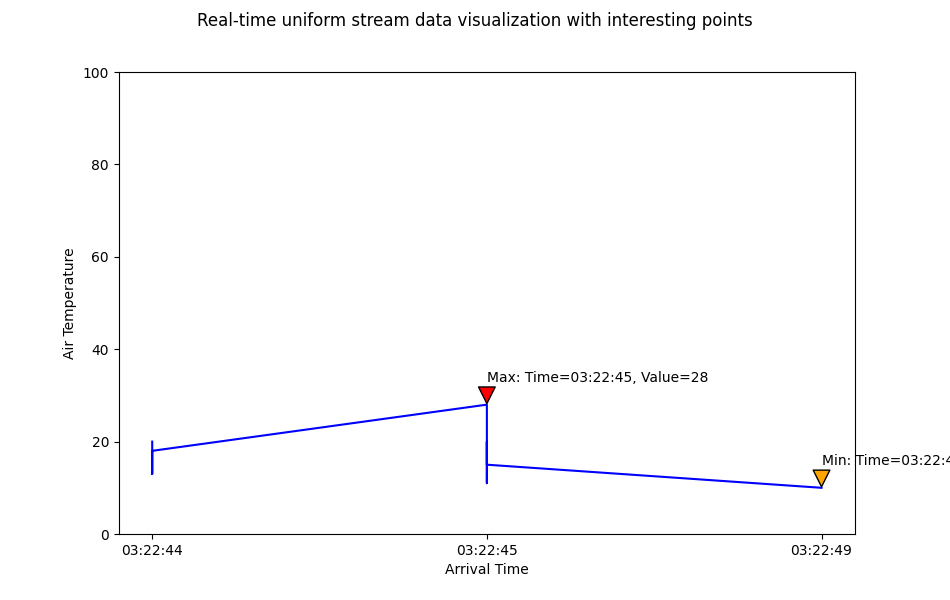

KeyboardInterrupt: 

In [2]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import ast

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'PartB'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
         #   print(message)
          #  dt.datetime.now().strftime("%X")
          #  data = str(message.value.decode('utf-8')).split(', ')
          #  print(data[0])
            lst = ast.literal_eval(message.value.decode('utf-8'))
         #   print(lst)
            #data = str(message.value.decode('utf-8')).split(', ')
            if lst['Producer_id'] == 'Producer_01':
                temperature = lst['air_temperature_celcius']
                x.append(dt.datetime.now().strftime("%X"))
                y.append(int(temperature))
                # we start plotting only when we have 10 data points
                if len(y) > 10:
                    ax.clear()
                    ax.plot(x, y,color='blue')
                    ax.set_xlabel('Arrival Time')
                    ax.set_ylabel('Air Temperature')
                    ax.set_ylim(0,100) 
                    ax.set_yticks([0,20,40,60,80,100])
                    annotate_max(x,y,ax)
                    annotate_min(x,y,ax)
                    fig.canvas.draw()
                    x.pop(0) # removing the item in the first position
                    y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    
    

# Part B Task 2.2a Static Data Visualization

In [3]:
for i in mydb.streaming_hotspot_collection.find():
    print(i)

{'_id': ObjectId('628a70c025967c93f524f0ee'), 'longitude': 142.8294, 'latitude': -37.7619, 'confidence': 71.0, 'surface_temperature': 46.0, 'Date': datetime.datetime(2022, 1, 11, 19, 12), 'Date_str': '2022-01-11'}
{'_id': ObjectId('628a70c025967c93f524f0ef'), 'longitude': 143.28, 'latitude': -36.939, 'confidence': 100.0, 'surface_temperature': 59.0, 'Date': datetime.datetime(2022, 1, 11, 9, 36), 'Date_str': '2022-01-11'}
{'_id': ObjectId('628a70ca25967c93f524f0f1'), 'longitude': 140.9956, 'latitude': -36.7257, 'confidence': 78.0, 'surface_temperature': 51.0, 'Date': datetime.datetime(2022, 1, 12, 19, 12), 'Date_str': '2022-01-12'}
{'_id': ObjectId('628a70de25967c93f524f0f4'), 'longitude': 148.9446, 'latitude': -37.1521, 'confidence': 66.0, 'surface_temperature': 46.0, 'Date': datetime.datetime(2022, 1, 14, 19, 12), 'Date_str': '2022-01-14'}
{'_id': ObjectId('628a70f225967c93f524f0f7'), 'longitude': 141.4938, 'latitude': -36.2127, 'confidence': 78.0, 'surface_temperature': 51.0, 'Date':

In [4]:
test = mydb.streaming_hotspot_collection.aggregate([

 { 
    "$group":{ "_id": { "$hour":"$Date"},
       'count':{"$sum":1} 
   }
 }])


hour, count = [],[]
for res in test: 
    print(res)
    hour.append(res['_id'])
    count.append(res['count'])
print(hour,count)

{'_id': 14, 'count': 6}
{'_id': 19, 'count': 7}
{'_id': 0, 'count': 6}
{'_id': 4, 'count': 3}
{'_id': 9, 'count': 3}
[14, 19, 0, 4, 9] [6, 7, 6, 3, 3]


<IPython.core.display.Javascript object>


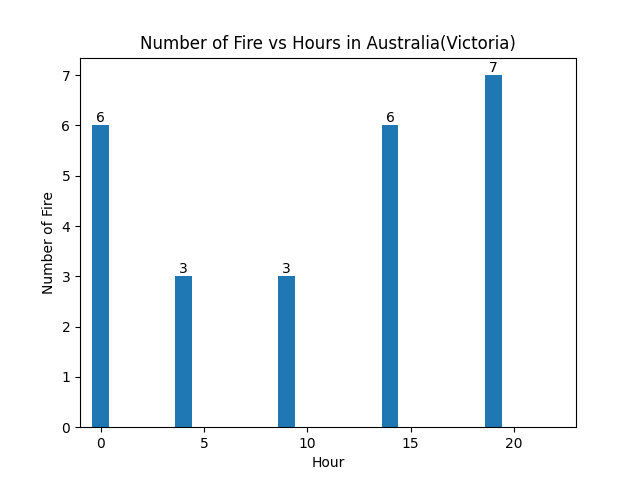

[Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '6'),
 Text(0, 0, '3'),
 Text(0, 0, '3')]

In [6]:
fig, ax = plt.subplots()
bars = ax.bar(hour, count)
ax.set_xlim(-1,23)
ax.set_title('Number of Fire vs Hours in Australia(Victoria)')
ax.set_ylabel('Number of Fire')
ax.set_xlabel('Hour')
ax.bar_label(bars)

# Part B Task 2.2b Static Data Visualization

In [7]:
import folium

In [10]:
results = mydb.streaming_hotspot_collection.aggregate([
    {
        "$lookup":{
            "from":"streaming_climate_collection",
            "localField": "Date_str",
            "foreignField": "date",
            "as":"climate"
        }
    },
    {
        "$project":
        {
            'longitude':1,
            'latitude':1,  
            "surface_temperature":1,
            'confidence':1, 
            'climate':{"Fire_Cause":1,"air_temperature_celcius":1,"relative_humidity":1}}
    },
    
    {'$unwind':'$climate'}
        
    
    
])
fomap = folium.Map(location=[-37.020100,144.964600],zoom_start=15)

for x in results: 
    latitude =  float(x['latitude'])
    longitude =  float(x['longitude'])
    lst = [latitude,longitude]
    confidence = x.get('confidence')
    surface_temperature = x.get('surface_temperature')
    relative_humidity = x.get('climate')['relative_humidity']
    air_temperature_celcius = x.get('climate')['air_temperature_celcius']
    fire_cause = x.get('climate')['Fire_Cause']
    details = f'Air Temp: {air_temperature_celcius}\nSurface Temp: {surface_temperature}\nConfidence:{confidence}\nRelative Humidity: {relative_humidity}'
    if fire_cause == 'other':
        folium.Marker(
            location=lst,
            popup=details,
            icon=folium.Icon(color="red", icon="info-sign")
        ).add_to(fomap)
    elif fire_cause == 'natural':
        folium.Marker(
            location=lst,
            popup=details,
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(fomap)
                     
                           
    

        
    

In [11]:
fomap

In [12]:
fomap.save('mymap.html')